In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
import joblib
import pickle

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import shutil
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def process_reppu_data():
    #path = r'/home/ryuho/Documents/reddy/research/SMRAI/Data/REPPU/200/pbig5min.dat' #Ubuntu
    path = r'/home/sachin/Documents/NIPR/Research/Data/REPPU/pbig5min.dat' #Server

    #read the REPPU data
    with open (path) as f:
        rectype = np.dtype(np.float32)
        reppu_data = np.fromfile(f, rectype) #size = 109,900,800

    reppu_data = reppu_data.reshape(-1,30,80)
    reppu_data = reppu_data.mean(axis=1).mean(axis=1) #integrate over the 30x80 grid

    #load MHD dates to match with REPPU data
    mhd_data = pd.read_csv('mhd_dates.csv')
    expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
        for start, end in zip(mhd_data['start'], mhd_data['end'])])
    
    time = np.arange(288)
    dt = []
    for day in expanded_dt:
        for t in time:
            dt.append(day + pd.Timedelta(minutes=t*5))
    dt = np.array(dt) #convert from list to numpy array
    df = pd.DataFrame(reppu_data, index=dt)
    df = df.rename(columns={0:'pot'})
    df.reset_index(inplace=True)
    df.rename(columns={'index':'dt'}, inplace=True)

    return df

reppu_df = process_reppu_data()
reppu_df   

,dt,pot
0,2021-05-10 00:00:00,5484.762695
1,2021-05-10 00:05:00,5247.855957
2,2021-05-10 00:10:00,5592.299805
3,2021-05-10 00:15:00,5834.336914
4,2021-05-10 00:20:00,5604.553711
...,...,...
45787,2022-08-19 23:35:00,-12768.093750
45788,2022-08-19 23:40:00,-13011.533203
45789,2022-08-19 23:45:00,-12235.481445
45790,2022-08-19 23:50:00,-9142.743164


In [4]:
def process_omni_and_merge(reppu_df):
    reppu_df = reppu_df.copy()
    
    omni_df = pd.read_csv('omni_mhd_5min.csv')
    omni_df = omni_df.ffill().bfill() #interpolate missing values
    omni_df = omni_df.dropna() 
    omni_df['dt'] = pd.to_datetime(omni_df['dt'])

    #merge the REPPU and OMNI data
    df = pd.merge(reppu_df, omni_df, on='dt', how='outer')
    df = df[(df['dt'] >= '2021-12-01') & (df['dt'] <= '2022-01-24')]
    df['pot'] = df['pot'] * 1e-3

    return df

df = process_omni_and_merge(reppu_df)
df

,dt,pot,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle
9216,2021-12-01 00:00:00,6.766367,9.20,0.85,443.0,7.80,-0.431351
9217,2021-12-01 00:05:00,7.072441,7.67,3.45,444.0,7.93,-0.434738
9218,2021-12-01 00:10:00,6.628429,6.28,-1.59,454.0,9.79,-0.438102
9219,2021-12-01 00:15:00,6.623042,3.55,0.46,460.0,10.19,-0.441440
9220,2021-12-01 00:20:00,6.612976,4.40,4.48,451.0,9.48,-0.444752
...,...,...,...,...,...,...,...
24764,2022-01-23 23:40:00,10.750388,-2.84,1.65,338.0,5.83,-0.357979
24765,2022-01-23 23:45:00,8.892503,-2.93,1.13,333.0,6.10,-0.361470
24766,2022-01-23 23:50:00,6.525692,-2.51,0.29,329.0,6.24,-0.364951
24767,2022-01-23 23:55:00,5.708533,0.30,1.77,339.0,7.55,-0.368420


In [5]:
def single_feat_df(df, lookback):
    df = df.copy()
    df = df[['dt','pot']]

    df.set_index('dt', inplace=True)
    
    for i in range(1, lookback+1):
        df[f'pot(t-{i})'] = df['pot'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

df = single_feat_df(df, 6)
df

,pot,pot(t-1),pot(t-2),pot(t-3),pot(t-4),pot(t-5),pot(t-6)
dt,,,,,,,
2021-12-01 00:30:00,6.072877,6.456231,6.612976,6.623042,6.628429,7.072441,6.766367
2021-12-01 00:35:00,5.601617,6.072877,6.456231,6.612976,6.623042,6.628429,7.072441
2021-12-01 00:40:00,4.966726,5.601617,6.072877,6.456231,6.612976,6.623042,6.628429
2021-12-01 00:45:00,5.928544,4.966726,5.601617,6.072877,6.456231,6.612976,6.623042
2021-12-01 00:50:00,6.909841,5.928544,4.966726,5.601617,6.072877,6.456231,6.612976
...,...,...,...,...,...,...,...
2022-01-23 23:40:00,10.750388,14.625016,10.748952,6.767097,5.409276,4.425746,4.264808
2022-01-23 23:45:00,8.892503,10.750388,14.625016,10.748952,6.767097,5.409276,4.425746
2022-01-23 23:50:00,6.525692,8.892503,10.750388,14.625016,10.748952,6.767097,5.409276


In [6]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [7]:
def scale_split_tensor(df):
    #X = df.drop(columns=['dt', 'Potential'])
    #y = df['Potential']
    X = df.iloc[:, 1:]
    y = df.iloc[:, 0]

    #scale the data
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    split_index = int(0.8*len(X))#80% train, 20% test

    #split the data
    X_train = X[:split_index]
    X_test = X[split_index:]
    y_train = y[:split_index]
    y_test = y[split_index:]

    #add exta dim for torch reqs
    X_train = X_train.reshape(-1, 6, 1)
    X_test = X_test.reshape(-1, 6, 1)
    y_train = y_train.values.reshape(-1, 1)
    y_test = y_test.values.reshape(-1, 1)

    #convert to tensor
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor

X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = scale_split_tensor(df)

In [8]:
X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape

(torch.Size([12437, 6, 1]),
 torch.Size([3110, 6, 1]),
 torch.Size([12437, 1]),
 torch.Size([3110, 1]))

In [9]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 6, 1]) torch.Size([16, 1])


In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 2)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, num_layers=2, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [30]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [31]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [32]:
learning_rate = 0.01
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 2.394
Batch 200, Loss: 2.779
Batch 300, Loss: 2.671
Batch 400, Loss: 2.240
Batch 500, Loss: 2.547
Batch 600, Loss: 2.744
Batch 700, Loss: 2.554

Val Loss: 1.792
***************************************************

Epoch: 2
Batch 100, Loss: 3.768
Batch 200, Loss: 1.854
Batch 300, Loss: 3.134
Batch 400, Loss: 2.078
Batch 500, Loss: 2.314
Batch 600, Loss: 2.068
Batch 700, Loss: 2.171

Val Loss: 1.967
***************************************************

Epoch: 3
Batch 100, Loss: 2.798
Batch 200, Loss: 3.203
Batch 300, Loss: 2.464
Batch 400, Loss: 2.546
Batch 500, Loss: 2.387
Batch 600, Loss: 2.011
Batch 700, Loss: 2.483

Val Loss: 2.166
***************************************************

Epoch: 4
Batch 100, Loss: 2.737
Batch 200, Loss: 2.655
Batch 300, Loss: 2.158
Batch 400, Loss: 3.202
Batch 500, Loss: 2.300
Batch 600, Loss: 2.186
Batch 700, Loss: 2.061

Val Loss: 1.749
***************************************************

Epoch: 5
Batch 100, Loss: 2.040
Batch 20

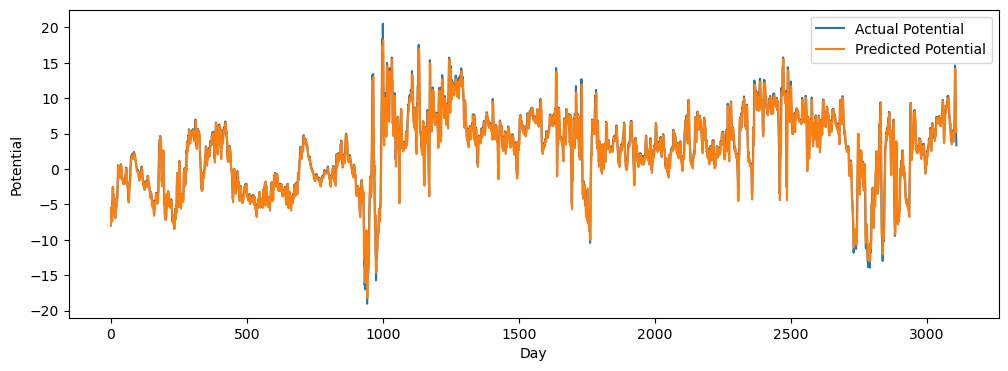

In [34]:
with torch.no_grad():
    predicted = model(X_test_tensor.to(device)).to('cpu')

plt.figure(figsize=(12, 4))
y_train_tensor = y_test_tensor.to('cpu')
plt.plot(y_train_tensor, label='Actual Potential')
plt.plot(predicted, label='Predicted Potential')
plt.xlabel('Day')
plt.ylabel('Potential')
plt.legend()
#plt.show()

In [15]:
def train_and_validate(epochs, model, train_loader, test_loader, optimizer, loss_function, device):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train(True)  # Set the model to train mode
        print(f'Epoch: {epoch + 1}')
        running_loss = 0.0
        
        # Training loop
        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_index % 100 == 99:  # print every 100 batches
                avg_loss_across_batches = running_loss / 100
                print('Training Batch {0}, Loss: {1:.3f}'.format(batch_index+1, avg_loss_across_batches))
                running_loss = 0.0
        
        train_losses.append(running_loss / len(train_loader))

        # Validation loop
        model.train(False)  # Set the model to evaluation mode
        running_loss = 0.0
        
        for batch_index, batch in enumerate(test_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            
            with torch.no_grad():
                output = model(x_batch)
                loss = loss_function(output, y_batch)
                running_loss += loss.item()

        val_losses.append(running_loss / len(test_loader))
        
        print('Validation Loss: {0:.3f}'.format(val_losses[-1]))

    return train_losses, val_losses

#earning_rate = 0.001
#num_epochs = 10
#loss_function = nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#train_losses, val_losses = train_and_validate(num_epochs, model, train_loader, test_loader, optimizer, loss_function, device)
